# ~~Energy~~ Rigidity loss calculation with CRPropa3 

Based on the notebook `energy_loss.ipynb` but now doing instead for rigidity.

Based on this example for 1D simulation: https://crpropa.github.io/CRPropa3/pages/example_notebooks/sim1D/sim1D.v4.html

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy import units as u
import h5py

from crpropa import *

## Run the CRPropa3 Simulation for each Particle type

Do so so that we can observe the Rigidity effect with different nuclei.

In [2]:
# initial settings
D_src = 10   # Mpc
R_src = 10  # 10 EV

# particles to simulate
known_ptypes = {
    "p": (1, 1),
    "He": (4, 2),
    "N" : (14, 7),
    "Si" : (28, 14),
    "Fe" : (56, 26)
}

# number of source particless
N = 10_000

In [3]:
# iterate over each particle type
for i, (pt, ptup) in enumerate(list(known_ptypes.items())):

    # create simulation
    sim = ModuleList()
    sim.add( SimplePropagation(1*kpc, 10*Mpc) )
    sim.add( Redshift() )
    sim.add( PhotoPionProduction(CMB()) )
    sim.add( PhotoPionProduction(IRB_Kneiske04()) )
    sim.add( PhotoDisintegration(CMB()) )
    sim.add( PhotoDisintegration(IRB_Kneiske04()) )
    sim.add( NuclearDecay() )
    sim.add( ElectronPairProduction(CMB()) )
    sim.add( ElectronPairProduction(IRB_Kneiske04()) )
    sim.add( MinimumEnergy( 1 * EeV) )

    # observer and output
    obs = Observer()
    obs.add( ObserverPoint() )
    output = TextOutput(f'output/crpropa_events_{pt}.txt', Output.Event1D)
    obs.onDetection( output )
    sim.add( obs )

    # source
    source = Source()
    source.add( SourcePosition(D_src * Mpc) )
    source.add( SourceRedshift1D() )
    source_ptype = nucleusId(*ptup) 
    # evaluate source energy from R * Z
    E_src = R_src * ptup[1]
    source.add( SourceEnergy(E_src * EeV) )
    source.add( SourceParticleType(source_ptype) ) 

    # run simulation
    sim.setShowProgress(True)
    sim.run(source, N, True)
    output.close()


crpropa::ModuleList: Number of Threads: 128
Run ModuleList
  Started Wed Feb  8 14:32:04 2023 : [ Finished ] 100%    Needed: 00:00:00  - Finished at Wed Feb  8 14:32:04 2023
crpropa::ModuleList: Number of Threads: 128
Run ModuleList
  Started Wed Feb  8 14:32:07 2023 : [ Finished ] 100%    Needed: 00:00:00  - Finished at Wed Feb  8 14:32:07 2023
crpropa::ModuleList: Number of Threads: 128
Run ModuleList
  Started Wed Feb  8 14:32:10 2023 : [ Finished ] 100%    Needed: 00:00:01  - Finished at Wed Feb  8 14:32:11 2023
crpropa::ModuleList: Number of Threads: 128
Run ModuleList
  Started Wed Feb  8 14:32:14 2023 : [ Finished ] 100%    Needed: 00:00:00  - Finished at Wed Feb  8 14:32:14 2023
crpropa::ModuleList: Number of Threads: 128
Run ModuleList
  Started Wed Feb  8 14:32:17 2023 : [ Finished ] 100%    Needed: 00:00:01  - Finished at Wed Feb  8 14:32:18 2023


## Get output and analyze

In [4]:
# define arrays
Z_ptypes = []
Z0_ptypes = []
A_ptypes = []
A0_ptypes = []
E_ptypes = []
E0_ptypes = []

In [5]:
# iterate over each particle type
for i, pt in enumerate(list(known_ptypes.keys())):
    # get datafile
    sim_data = np.genfromtxt(f'output/crpropa_events_{pt}.txt', names=True)

    # Observed quantities
    Z = np.array([chargeNumber(int(id)) for id in sim_data['ID'].astype(int)])  # element
    Z0 = np.array([chargeNumber(int(id)) for id in sim_data['ID0'].astype(int)])
    A = np.array([massNumber(int(id)) for id in sim_data['ID'].astype(int)])  # atomic mass number
    A0 = np.array([massNumber(int(id)) for id in sim_data['ID0'].astype(int)])
    log10E = np.log10(sim_data['E']) + 18  # energy in log10(E/eV))
    log10E0 = np.log10(sim_data['E0']) + 18  # energy in log10(E/eV))
    E = 10**log10E
    E0 = 10**log10E0

    # How many final particles per source particles
    Nout = len(Z)
    print(f"Particle fraction at arrival: {Nout / N:.2f}")

    # append all into list
    Z_ptypes.append(Z)
    Z0_ptypes.append(Z0)
    A_ptypes.append(A)
    A0_ptypes.append(A0)
    E_ptypes.append(E)
    E0_ptypes.append(E0)

Particle fraction at arrival: 1.00
Particle fraction at arrival: 1.16
Particle fraction at arrival: 3.80
Particle fraction at arrival: 5.92
Particle fraction at arrival: 12.12


### Plot rigidity fraction, Rsrc / Rarr

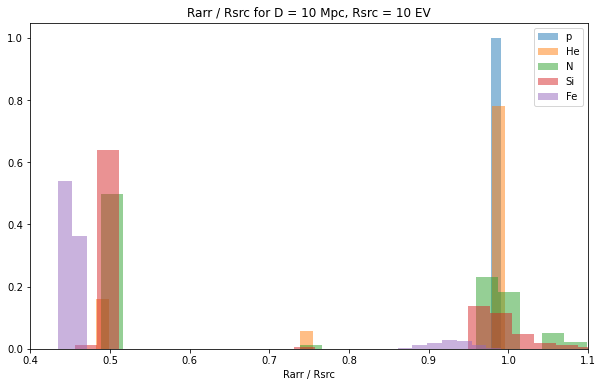

In [6]:
# plot rigidity fraction, normalized by number of particles

xlims = [
    [0.5, 1.0], [0.4, 0.6], [0.45, 1.2], [0.4, 1.2], [0.4, 1.1]
]

# plot histogram
fig, ax = plt.subplots(figsize=(10,6))

# rigidity fraction
for i, pt in enumerate(list(known_ptypes.keys())):
    # first evaluate rigidities
    # we want rigidity of all charged particles (rigidity of neutron == 0)
    Z_nonzero_idces = np.argwhere(Z_ptypes[i] != 0)
    R = E_ptypes[i][Z_nonzero_idces] / Z_ptypes[i][Z_nonzero_idces]

    # do similarly for R0 to match indices
    R0 = E0_ptypes[i][Z_nonzero_idces] / Z0_ptypes[i][Z_nonzero_idces]

    # rigidity fraction
    Rfrac = R / R0

    # total number of particles different for each particle type
    N_arr = len(Rfrac)

    # divide by total number of particles
    weights = (1. / N_arr) * np.ones(N_arr)

    # set bins by minimum and maximal rigidity fraction
    bins = np.linspace(np.min(Rfrac), np.max(Rfrac))

    ax.hist(Rfrac, bins=50, alpha=0.5, weights = weights, label=f"{pt}");
    ax.set_xlabel("Rarr / Rsrc")
    ax.set_title(f"Rarr / Rsrc for D = {D_src} Mpc, Rsrc = {R_src} EV")

    ax.set_xlim(xlims[i])
    ax.legend()

### Plot Rigidity fraction, Rarr / Rsrc for all particles A / Z > 1

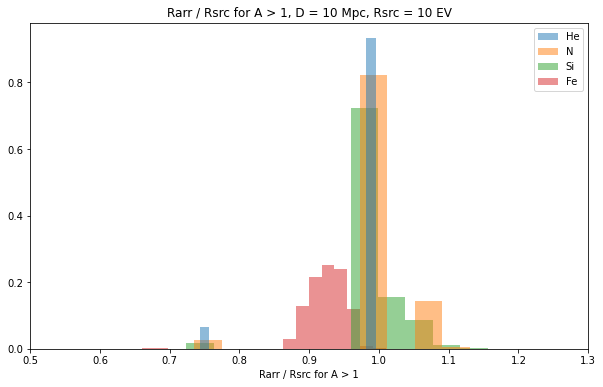

In [8]:
# plot rigidity fraction, normalized by number of particles, for A / Z > 1 (nuclei)

# plot histogram
fig, ax = plt.subplots(figsize=(10,6))

# rigidity fraction 
for i, pt in enumerate(list(known_ptypes.keys())):
    if pt == "p":
        continue
    # first evaluate rigidities
    # we want rigidity of all charged particles (rigidity of neutron == 0)
    Z_nonzero_idces = np.argwhere(Z_ptypes[i] != 0)
    R = E_ptypes[i][Z_nonzero_idces] / Z_ptypes[i][Z_nonzero_idces]

    # do similarly for R0 to match indices
    R0 = E0_ptypes[i][Z_nonzero_idces] / Z0_ptypes[i][Z_nonzero_idces]

    # rigidity fraction
    Rfrac = R / R0

    # cutoff Rfrac such that we only plot those with A / Z > 1
    Rfrac = Rfrac[A_ptypes[i][Z_nonzero_idces] > 1]

    # total number of particles different for each particle type
    N_arr = len(Rfrac)

    # divide by total number of particles
    weights = (1. / N_arr) * np.ones(N_arr)

    # set bins by minimum and maximal rigidity fraction
    bins = np.linspace(np.min(Rfrac), np.max(Rfrac), 20)

    ax.hist(Rfrac, bins=bins, alpha=0.5, weights = weights, label=f"{pt}", zorder=4-i);
    ax.set_xlabel("Rarr / Rsrc for A > 1")
    ax.set_title(f"Rarr / Rsrc for A > 1, D = {D_src} Mpc, Rsrc = {R_src} EV")

    ax.set_xlim([0.5, 1.3])
    ax.legend()

## Other histograms can be plotted below

Commented out for now

In [28]:
# # mass number
# for i, pt in enumerate(list(known_ptypes.keys())):
#     fig, ax = plt.subplots()
#     ax.hist(A0_ptypes[i], alpha=0.5, label="Mass number (source)")
#     ax.hist(A_ptypes[i], alpha=0.5, label="Mass number (arrival)")
#     ax.set_xlabel("Mass Number")
#     ax.set_xlim(xmax=known_ptypes[pt][0] + 5)
#     ax.set_title(f"Mass Number distribution for {pt}")
#     ax.legend()

In [29]:
# # charge number
# for i, pt in enumerate(list(known_ptypes.keys())):
#     fig, ax = plt.subplots()
#     ax.hist(Z0_ptypes[i], alpha=0.5, label="Charge (source)");
#     ax.hist(Z_ptypes[i], alpha=0.5, label="Charge (arrival)");
#     ax.set_xlabel("Charge")
#     ax.set_xlim(xmax=known_ptypes[pt][1] + 5)
#     ax.set_title(f"Charge distribution for {pt}")
#     ax.legend()

In [30]:
# # energy
# Emin = 0.1 * u.EeV
# Emax = 1e5 * u.EeV
# E_range = 10**np.linspace(np.log10(Emin.to_value(u.eV)), np.log10(Emax.to_value(u.eV)))

# for i, pt in enumerate(list(known_ptypes.keys())):
#     fig, ax = plt.subplots()
#     ax.hist(E0_ptypes[i], bins=E_range, alpha=0.5, label="Energy (source)");
#     ax.hist(E_ptypes[i], bins=E_range, alpha=0.5, label="Energy (arrival)");
#     ax.axvline(57e18, color="k", label="Threshold energy (TA15)", linestyle=":")
#     ax.set_yscale("log")
#     ax.set_xscale("log")
#     ax.set_xlabel("E / eV")
#     ax.set_title(f"Energy distribution for {pt}")
#     ax.legend()

In [31]:
# # energy per nucleon
# Emin = 0.1 * u.EeV
# Emax = 1e5 * u.EeV
# E_range = 10**np.linspace(np.log10(Emin.to_value(u.eV)), np.log10(Emax.to_value(u.eV)))

# for i, pt in enumerate(list(known_ptypes.keys())):
#     fig, ax = plt.subplots()
#     ax.hist(E0_ptypes[i] / A0_ptypes[i], bins=E_range, alpha=0.5, label="E / A (source)");
#     ax.hist(E_ptypes[i] / A_ptypes[i], bins=E_range, alpha=0.5, label="E / A (arrival)");
#     ax.axvline(57e18 / known_ptypes[pt][0], color="k", label="E_thr / A0 (TA15)", linestyle=":")
#     ax.set_yscale("log")
#     ax.set_xscale("log")
#     ax.set_xlabel("E / A")
#     ax.set_title(f"Energy per nucleon distribution for {pt}, D = {D_src} Mpc")
#     ax.legend()